In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import isnan

class Todoroff:
    def __init__(self,file):
        self.file=file
    def import_csv(self):
        if (not self.file.endswith('.csv')):
            file = self.file + ".csv"
        else:
            file = self.file
        df = pd.read_csv(file,skiprows=0)
        #df=df.drop([0,1])
        unique_timestamps=df["TIMESTAMP"].nunique()
        if unique_timestamps ==1:
            timestamp = df.loc[2]["TIMESTAMP"]
            date, time = timestamp.split(" ")
            Vp=df.loc[2]["Vp"]
            WaveAvg=df.loc[2]["Averages"]
            points=df.loc[2]["Points"]
            cablelen=df.loc[2]["CableLen"]
            windowlen=df.loc[2]["WindowLen"]
            probelen=df.loc[2]["ProbeLen"]
            Vp=float(Vp)
            points=int(points)
            windowlen=int(windowlen)
            probelen=float(probelen)
            measurements = df.loc[2]["Waveform(1)":] # extract measurements from Waveform 1 row
            measurements = measurements.astype(float)  # convert to float type
            measurements = measurements[~isnan(measurements)]  # filter out NaN values
            measurements.iloc[0]=0 #setting the beginning of the trace to zero
        else:
            timestamp = df["TIMESTAMP"]
            Vp=df["Vp"]
            WaveAvg=df["AverageCnt"]
            points=df["PointsCnt"]
            cablelen=df["CableLen"]
            windowlen=df["WindowLen"]
            probelen=df["ProbeLen"]
            Vp=Vp.astype(float)
            points=points.astype(int)
            windowlen=windowlen.astype(int)
            probelen=probelen.astype(float)
            selected_columns=[]
            for i in range(1,points.loc[2]+1):
                selected_columns.append(f"Waveform({i})")
            measurements=df[selected_columns].copy()
            measurements = measurements.astype(float)  # convert to float type
            measurements = measurements[~isnan(measurements)]  # filter out NaN values
            measurements["Waveform(1)"]=0
        return timestamp, Vp, WaveAvg, points, cablelen, windowlen, probelen, measurements
    
    def impulse_response(self):
        timestamp, Vp, WaveAvg, points, cablelen, windowlen, probelen, measurements=self.import_csv()
        self.LightSpeed=3*(10**8)
        #Vp=Vp.astype(float)
        #points=points.astype(int)
        #windowlen=windowlen.astype(float)
        num_rows = points.shape[0]
        for idx in points.index:
            num_points=points.loc[idx]
            WaveformApparentDistance=np.zeros((num_rows,num_points))
            WaveformResponseTime=np.zeros((num_rows,num_points))
            ImpulseResponse=np.zeros((num_rows,num_points))
            Reflectedsignal=measurements.values
            VDown = [np.zeros((num_points, num_points)) for _ in range(num_rows)]
            for j in range(num_rows):
                WaveformApparentDistance[j,0]=0
                ImpulseResponse[j,0]=0
                for i in range(1, num_points):
                    WaveformApparentDistance[j,i] = WaveformApparentDistance[j,i - 1] + (windowlen.loc[idx] / (points.loc[idx] - 1))
                    WaveformResponseTime[j,i] = (2 * WaveformApparentDistance[j,i] / (self.LightSpeed * Vp.loc[idx]))*1000000000
                for i in range(0, num_points):
                    Reflectedsignal[j,i]=Reflectedsignal[j,i]-1
                for i in range(1, num_points-1):
                    ImpulseResponse[j,i] = Reflectedsignal[j,i+1]-Reflectedsignal[j,i]
                for i in range(0, num_points):
                    VDown[j][i, 0] = ImpulseResponse[j,i]
                    
        return WaveformApparentDistance, WaveformResponseTime, ImpulseResponse, VDown

    def Selectstartendprobe(self):
        timestamp, Vp, WaveAvg, points, cablelen, windowlen, probelen, measurements=self.import_csv()
        WaveformApparentDistance, WaveformResponseTime, ImpulseResponse, VDown=self.impulse_response()
        num_rows = points.shape[0]
        for idx in points.index:
            num_points=points.loc[idx]
            Segments=np.zeros((num_rows, num_points))
            dy_dt=np.zeros((num_rows,num_points))
            dy_dt2=np.zeros((num_rows,num_points))
            dy_dt_alt=np.zeros((num_rows,num_points))
            measur=measurements.values
            #points=points.astype(int)
            for j in range(num_rows):
                Segments[j]=np.arange(1,num_points+1)
                for i in range(0, len(WaveformResponseTime[j])-1):
                    dy_dt[j,i]=((measur[j,i+1]-measur[j,i])/(WaveformResponseTime[j,i+1]-WaveformResponseTime[j,i]))
                dy_dt[j,num_points-1]=-measur[j,num_points-1]/-WaveformResponseTime[j,num_points-1]
                for i in range(0, len(WaveformResponseTime[j])-1):
                    dy_dt2=(dy_dt[j,i+1]-dy_dt[j,i])/(WaveformResponseTime[j,i+1]-WaveformResponseTime[j,i])
                #dy_dt2[j,num_points-1]=-dy_dt[j,num_points-1]/-WaveformResponseTime[j,num_points-1]
                for i in range(0, len(WaveformResponseTime[j])-2):
                    dy_dt_alt[j,i]=(measur[j,i+2]-measur[j,i])/(WaveformResponseTime[j,i+2]-WaveformResponseTime[j,i])
                #dy_dt_alt[j,num_points-2]=(-measurements[j,points-1]/-WaveformResponseTime[j,points-1])
        peak_indices = []
        # Iterate over each array dy_dt[j]
        for j in range(len(dy_dt)):
            # Get the indices of the 20 highest peaks in dy_dt[j]
            indices = sorted(range(len(dy_dt[j])), key=dy_dt[j].__getitem__, reverse=True)[:20]
            peak_indices.append(indices)
      
        return Segments,dy_dt, dy_dt2, dy_dt_alt, peak_indices
            
    def forwardmodel(self):
        timestamp, Vp, WaveAvg, points, cablelen, windowlen, probelen, measurements=self.import_csv()
        WaveformApparentDistance, WaveformResponseTime, ImpulseResponse, VDown=self.impulse_response()
        #points=points.astype(int)
        num_rows = points.shape[0]
        for idx in points.index:
            num_points=points.loc[idx]
            Vup = [np.zeros((num_points, num_points)) for _ in range(num_rows)]
            Segmentreflcoef=[np.zeros((1,num_points)) for _ in range(num_rows)]
        for x in range(num_rows):
            Vup[x][0,0]=1
            Segmentreflcoef[x][0,0]=VDown[x][1,0]/Vup[x][0,0]
            Vup[x][0,1]=Vup[x][0,0]*(1+Segmentreflcoef[x][0,0])
            for j in range(1, num_points-1):
                VDown[x][j,1]=VDown[x][j+1,0]/(1-Segmentreflcoef[x][0,0])
                Vup[x][j,1]=-VDown[x][j,1]*Segmentreflcoef[x][0,0]
            Segmentreflcoef[x][0,1]=VDown[x][1,1]/Vup[x][0,1]
            Vup[x][0,2]= Vup[x][0,1]*(1+Segmentreflcoef[x][0,1])
            
            for i in range(2, num_points-1):
                for j in range(1, num_points-i):
                    VDown[x][j,i]= (VDown[x][j+1, i-1] - Segmentreflcoef[x][0, i-1]*Vup[x][j,i-1])/ (1-Segmentreflcoef[x][0,i-1])
                    Vup[x][i,j]= (1+Segmentreflcoef[x][0,i-1])*Vup[x][j,i-1] - Segmentreflcoef[x][0,i-1]*VDown[x][j,i]
                Segmentreflcoef[x][0,i]=VDown[x][1,i]/Vup[x][0,i]
                Vup[x][0,i+1]=Vup[x][0,i]*(1+Segmentreflcoef[x][0,i])

            original_values = np.cumsum(Segmentreflcoef[x])

        return Segmentreflcoef, original_values, VDown, Vup
    
    def inversemodel(self, idxfirst, idxsec, ProbeairImp):
        """
        idxfirst: The index of the first peak (start of the probe)
        idsxsec: The index of the second peak (end of the probe)
        ProbeairImp: Impendance of the probe in the air

        """
        timestamp, Vp, WaveAvg, points, cablelen, windowlen, probelen, measurements=self.import_csv()
        WaveformApparentDistance, WaveformResponseTime, ImpulseResponse, VDown=self.impulse_response()
        Segmentreflcoef, original_values, VDown, Vup=self.forwardmodel()
        ProbeairImp=140
        num_rows = points.shape[0]
        Ka_all=[]
        lenact_all=[]
        for idx in points.index:
            num_points=points.loc[idx]
            Impendance=[np.zeros((1,num_points)) for _ in range(num_rows)]
            DielectricConstant=np.zeros((num_rows,num_points))
            Actuallength=np.zeros((num_rows,num_points))
            length=np.zeros((num_rows,num_points))
            for j in range(num_rows):
                Traveltime=(WaveformResponseTime[j,2]-WaveformResponseTime[j,1])/1000000000
                Impendance[j][0,0]=50
                for i in range(1, num_points):
                    Impendance[j][0,i]=Impendance[j][0,i-1]*((1+Segmentreflcoef[j][0,i-1])/(1-Segmentreflcoef[j][0,i-1]))
                for i in range(idxfirst,idxsec+1):
                    DielectricConstant[j,i]=(ProbeairImp/Impendance[j][0,i])**2
                    Actuallength[j,i]=(Traveltime*self.LightSpeed)/(2*(DielectricConstant[j,i]**0.5))
                length[j,0]=Actuallength[j,0]
                for i in range(1,len(Actuallength[j])-1):
                    length[j,i]=Actuallength[j,i]+length[j,i-1]

        for j in range(num_rows):
            lenact=length[j][idxfirst-1:idxsec+1]
            Ka=DielectricConstant[j][idxfirst-1:idxsec+1]
            lenact_all.append(lenact)
            Ka_all.append(Ka)

        lenact_all = np.array(lenact_all)
        Ka_all = np.array(Ka_all)
        return Impendance, Ka_all, lenact_all
    def calibratewatercontent(self, ):
        return
    
    def watercontentcomp(self, idxfirst, idxsec, model='Topp', Topp_params=None, sample_depths=None, porosity=None, bulk_density=None, esoil=None):
        """

        model: string, 
        1.Topp
        2. Modified Topp
        3. Roth (1990)
        4. Modified Roth
        5. Malicki (1996)
        6. Modified Malicki (1996)

        """
        Impendance, Ka, lenact=self.inversemodel(idxfirst, idxsec)
        thetatop=np.zeros(len(Ka))
        thetaroth=np.zeros(len(Ka))
        thetamalicki=np.zeros(len(Ka))
        if model=="Topp":
            for i in range(0, len(Ka)):
                thetatop[i]=((-5.3*(10**(-2)))+(2.92*(10**(-2))*Ka[i])+(-5.5*(10**(-4))*(Ka[i]**2))+(4.3*(10**(-6))*(Ka[i]**3)))
        if model=="Roth":
            for i in range(0, len(Ka)):
                for j in range(len(sample_depths)):
                    if lenact[i] <= sample_depths[j]:
                        # Find the appropriate porosity value corresponding to the depth of the segment
                        current_porosity = porosity[j]
                        # Update thetaroth[i] using the current porosity value
                        thetaroth[i] = (Ka[i]**0.5 - (1 + current_porosity) * (5**0.5) - current_porosity * (1**0.5)) / (80**0.5 - 1**0.5)
                        break  # Exit the inner loop once the appropriate porosity is found
        if model=="Malicki":
            for i in range(0, len(Ka)):
                for j in range(len(sample_depths)):
                    if lenact[i] <= sample_depths[j]:
                        # Find the appropriate bulk density value corresponding to the depth of the segment
                        current_bulkdensity = bulk_density[j]
                        # Update thetamalicki[i] using the current porosity value
                        thetamalicki[i] = ((Ka[i]-0.819-0.168*current_bulkdensity-0.159*(current_bulkdensity)**2)**0.5)/(7.17+1.18*current_bulkdensity)
                        break  # Exit the inner loop once the appropriate bulk density is found
        return thetatop, thetaroth, thetamalicki, lenact



class TodoroffPlotter:
    def __init__(self, td):
        self.td = td

    def plot_reflcoefappdist(self):
       # Call the impulse_response method of the Todoroff instance
       timestamp, Vp, WaveAvg, points, cablelen, windowlen, probelen, measurements = self.td.import_csv()
       WaveformApparentDistance, WaveformResponseTime, ImpulseResponse, VDown= self.td.impulse_response()
       # Plotting
       num_rows = points.shape[0]
       if num_rows>10:
           num_subplots=num_rows//10
           rows_sub=num_rows//num_subplots
           fig, axs=plt.subplots(num_subplots, figsize=(10,10))
           for i, ax in enumerate(axs):
               for idx in points.index:
                   for j in range(num_rows):
                       start_idx=j* rows_sub
                       end_idx=start_idx +rows_sub
                       ax.plot(WaveformApparentDistance[start_idx:end_idx], measurements.loc[start_idx+2:end_idx+2], label=f'{timestamp[idx]}')
                       ax.set_xlabel('Distance (m)')
                       ax.set_ylabel('Reflection Coefficient')
                       ax.set_title(f'Reflection Coefficient - Apparent Distance {td.file} {i+1}')
                       ax.set_grid(True)
                       ax.set_legend()
        

    def plot_reflcoeftime(self):
       # Call the impulse_response method of the Todoroff instance
       timestamp, Vp, WaveAvg, points, cablelen, windowlen, probelen, measurements = self.td.import_csv()
       WaveformApparentDistance, WaveformResponseTime, ImpulseResponse, VDown= self.td.impulse_response()
       # Plotting
       plt.figure(figsize=(10, 6))
       plt.plot(WaveformResponseTime, measurements, label=f'{timestamp}')
       plt.xlabel('Time (ns)')
       plt.ylabel('Reflection Coefficient')
       plt.title('Reflection Coefficient - Time')
       plt.legend()
       plt.grid(True)
       plt.show()
    
    def plot_startendprobe(self):
        datetime, Vp, WaveAvg, points, cablelen, windowlen, probelen, measurements = self.td.import_csv()
        Segments,dy_dt, dy_dt2, dy_dt_alt, indices=self.td.Selectstartendprobe()
        plt.figure(figsize=(10,6))
        num_rows = points.shape[0]
        for j in range(num_rows):
            num_points=points.loc[j]
            plt.plot(Segments[j][indices[j][0]-20:indices[j][0]+int(num_points/5)], measurements.iloc[j,indices[j][0]-20:indices[j][0]+int(num_points/5)], color="black", label="Reflection Coefficient")
            plt.plot(Segments[j][indices[j][0]-20:indices[j][0]+int(num_points/5)], dy_dt[j][indices[j][0]-20:indices[j][0]+int(num_points/5)], color="purple", label="1st Derivative")
            plt.plot(Segments[j][:1024], measurements.iloc[j], color="black", label="Reflection Coefficient")
            plt.plot(Segments[j], dy_dt[j], color="purple", label="1st Derivative")
        #plt.plot(Segments[indices[0]-20:indices[0]+200], dy_dt2[indices[0]-20:indices[0]+200], color="red", label="2nd Derivative")
        plt.xlabel('Segments (1 : n)')
        plt.ylabel('Reflection Coefficient')
        plt.title('Reflection Coefficient - 1st Derivative')
        plt.legend()
        plt.grid(True)
        plt.show()
        print(f"These are the indices {indices[j]} of the 20 first maximum values of the 1st derivative. Select the first (start of the probe) and second (end of the probe) to insert to the inverse model for water content computation")
    
    def plot_modelvdimpulse(self):
        WaveformApparentDistance, WaveformResponseTime, ImpulseResponse, VDown= self.td.impulse_response()
        Segmentreflcoef, original_values, VDown, Vup=self.td.forwardmodel()
        plt.figure(figsize=(10,6))
        plt.plot(WaveformResponseTime, ImpulseResponse, label="Impulse Response")
        plt.plot(WaveformResponseTime, Segmentreflcoef[0], label="Modeled")
        plt.xlabel('Time (ns)')
        plt.ylabel('Impulse Response vs Model')
        plt.title('Implulse Response vs Model')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def plot_Impendance(self, idxfirst, idxsec):
        WaveformApparentDistance, WaveformResponseTime, ImpulseResponse, VDown= self.td.impulse_response()
        Impendance=self.td.inversemodel(idxfirst,idxsec)
        plt.figure(figsize=(10,6))
        plt.plot(WaveformResponseTime, Impendance[0], label="Impendance")
        plt.xlabel('Time (ns)')
        plt.ylabel('Impendance (Ohms)')
        plt.title('Impendance')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_DielectricConstant(self, idxfirst, idxsec):
        Impendance, Ka, lenact=self.td.inversemodel(idxfirst, idxsec)
        plt.figure(figsize=(10,6))
        plt.plot(Ka, -lenact, label="Dielectric constant")
        plt.xlabel('Dielectric constant')
        plt.ylabel('Depth (m.)')
        plt.title('Dielectric Constant - Depth')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    def plot_WaterContent(self, idxfirst, idxsec):
        theta, thetaroth,thetamalicki, lenact=self.td.watercontentcomp(idxfirst, idxsec)
        plt.figure(figsize=(10,6))
        plt.plot(theta, -lenact, label="Water Content ($m^3/m^3$)")
        plt.xlabel('Water Content ($m^3/m^3$)')
        plt.ylabel('Depth (m.)')
        plt.title('Water Content - Depth')
        plt.legend()
        plt.grid(True)
        plt.show()


In [4]:
df =pd.read_csv("Test_0.5sensors/1001.csv")

In [5]:
df

,Unnamed: 0,TIMESTAMP,RECORD,MuxChannel,AverageCnt,Vp,PointsCnt,CableLen,WindowLen,ProbeLen,...,Waveform(2040),Waveform(2041),Waveform(2042),Waveform(2043),Waveform(2044),Waveform(2045),Waveform(2046),Waveform(2047),Waveform(2048),Waveform(2049)
0,2,2024-06-12 14:56:00,0,1001,4,0.66,2048,1.2,10,0.5,...,0.966496,0.964308,0.965402,0.965402,0.964308,0.964308,0.965402,0.962121,0.961027,0
1,4,2024-06-12 14:57:00,2,1001,4,0.66,2048,1.2,10,0.5,...,0.965934,0.965934,0.965934,0.962650,0.961555,0.962650,0.961555,0.961555,0.961555,0
2,6,2024-06-12 14:58:00,4,1001,4,0.66,2048,1.2,10,0.5,...,0.962032,0.962032,0.963126,0.960938,0.960938,0.960938,0.960938,0.960938,0.960938,0
3,8,2024-06-12 14:59:00,6,1001,4,0.66,2048,1.2,10,0.5,...,0.964310,0.964310,0.964310,0.964310,0.961024,0.961024,0.963215,0.963215,0.959928,0
4,10,2024-06-12 15:00:00,8,1001,4,0.66,2048,1.2,10,0.5,...,0.964327,0.964327,0.964327,0.959948,0.961043,0.963232,0.959948,0.959948,0.958853,0
5,12,2024-06-12 15:01:00,10,1001,4,0.66,2048,1.2,10,0.5,...,0.966105,0.968298,0.965008,0.965008,0.965008,0.968298,0.965008,0.963912,0.965008,0
6,14,2024-06-12 15:02:00,12,1001,4,0.66,2048,1.2,10,0.5,...,0.969162,0.965873,0.966969,0.965873,0.965873,0.965873,0.962584,0.962584,0.962584,0
7,16,2024-06-12 15:03:00,14,1001,4,0.66,2048,1.2,10,0.5,...,0.966133,0.966133,0.966133,0.965037,0.965037,0.963941,0.965037,0.965037,0.961748,0
8,18,2024-06-12 15:04:00,16,1001,4,0.66,2048,1.2,10,0.5,...,0.963935,0.963935,0.963935,0.963935,0.962839,0.963935,0.962839,0.960647,0.960647,0
9,20,2024-06-12 15:05:00,18,1001,4,0.66,2048,1.2,10,0.5,...,0.966231,0.966231,0.962942,0.962942,0.964038,0.961846,0.962942,0.961846,0.958557,0


In [8]:
td=Todoroff("Test_0.5sensors/1001.csv")

In [9]:
timestamp, Vp, WaveAvg, points, cablelen, windowlen, probelen, measurements=td.import_csv()

In [10]:
points.loc[0]

2048

In [11]:
WaveformApparentDistance, WaveformResponseTime, ImpulseResponse, VDown=td.impulse_response()

In [332]:
Segments,dy_dt, dy_dt2, dy_dt_alt, peak_indices=td.Selectstartendprobe()

In [333]:
Segments

array([[1.000e+00, 2.000e+00, 3.000e+00, ..., 1.022e+03, 1.023e+03,
        1.024e+03],
       [1.000e+00, 2.000e+00, 3.000e+00, ..., 1.022e+03, 1.023e+03,
        1.024e+03],
       [1.000e+00, 2.000e+00, 3.000e+00, ..., 1.022e+03, 1.023e+03,
        1.024e+03],
       ...,
       [1.000e+00, 2.000e+00, 3.000e+00, ..., 1.022e+03, 1.023e+03,
        1.024e+03],
       [1.000e+00, 2.000e+00, 3.000e+00, ..., 1.022e+03, 1.023e+03,
        1.024e+03],
       [1.000e+00, 2.000e+00, 3.000e+00, ..., 1.022e+03, 1.023e+03,
        1.024e+03]])

In [299]:
len(measurements.loc[0])

1024

 ...]

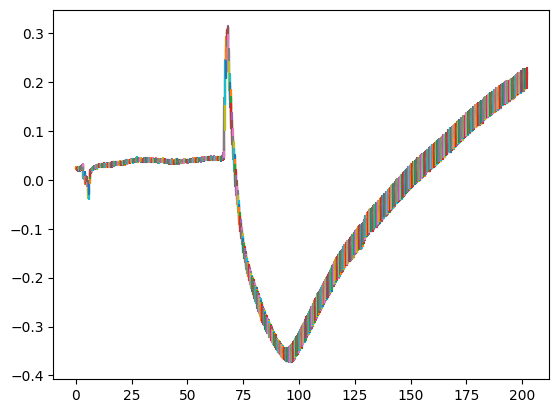

In [259]:
plt.plot(WaveformResponseTime,measurements)

In [353]:
Impendance, Ka, lenact=td.inversemodel(337,443,140)

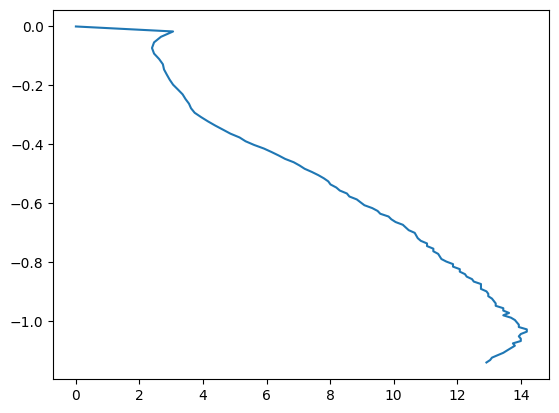

In [354]:
plt.plot(Ka[1],-lenact[1])

TypeError: 'Axes' object is not iterable

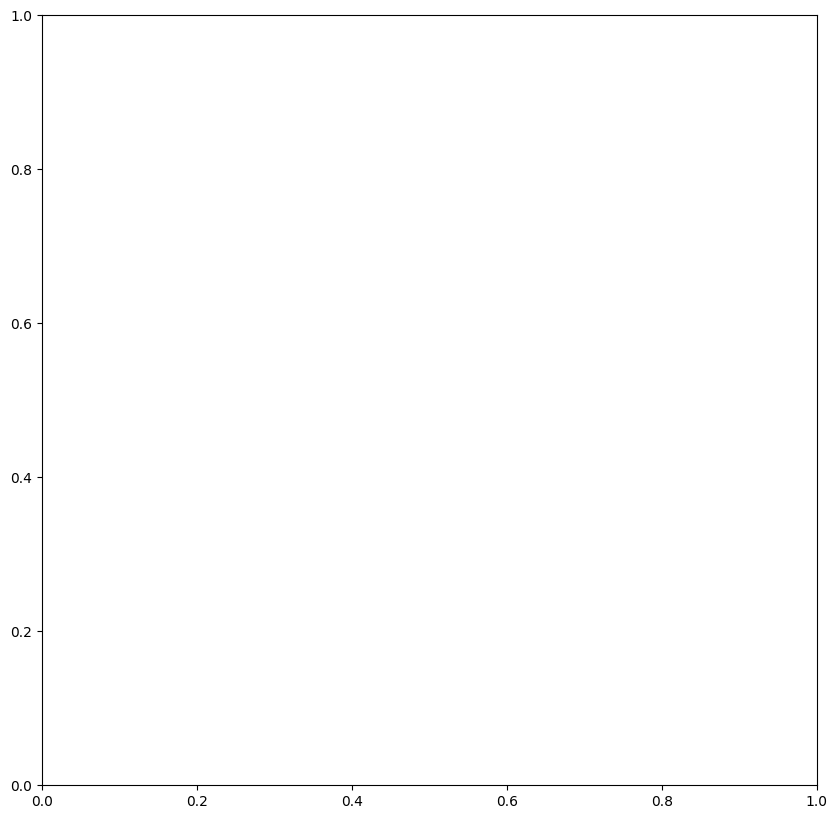

In [36]:
  # Plotting
num_rows = points.shape[0]
if num_rows>10:
    num_subplots=num_rows//10
    rows_sub=num_rows//num_subplots
    fig, axs=plt.subplots(num_subplots, figsize=(10,10))
    for i, ax in enumerate(axs):
          for idx in points.index:
                for j in range(num_rows):
                    start_idx=j* rows_sub
                    end_idx=start_idx +rows_sub
                    ax.plot(WaveformApparentDistance[start_idx:end_idx][:], measurements.loc[start_idx+2:end_idx+2], label=f'{timestamp[idx]}')
                    ax.set_xlabel('Distance (m)')
                    ax.set_ylabel('Reflection Coefficient')
                    ax.set_title(f'Reflection Coefficient - Apparent Distance {td.file} {i+1}')
                    ax.set_grid(True)
                    ax.set_legend()

In [351]:
plotter=TodoroffPlotter(td)

In [296]:
plotter.plot_reflcoeftime()

ValueError: Image size of 857x270332 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1000x600 with 1 Axes>

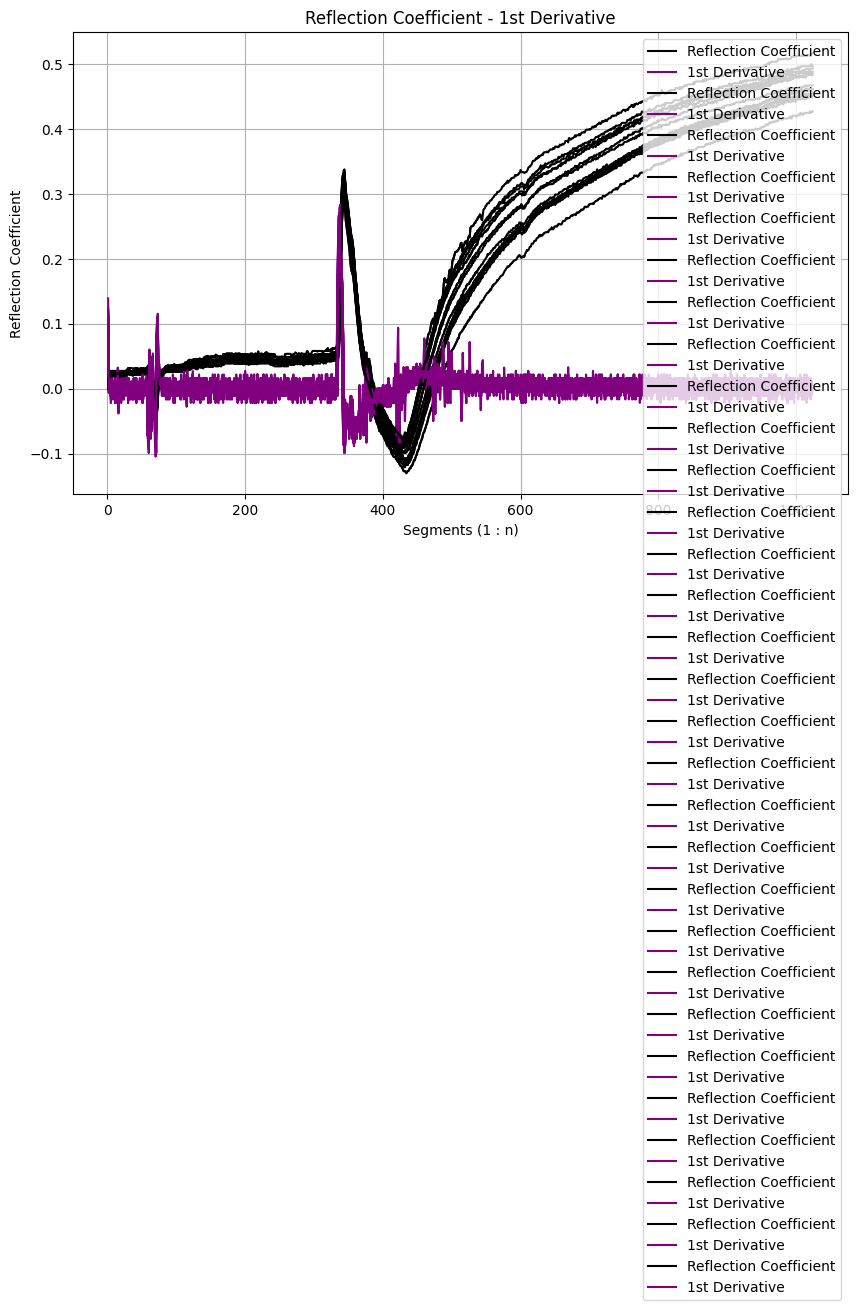

These are the indices [336, 335, 337, 338, 339, 334, 0, 71, 340, 72, 60, 333, 73, 443, 74, 440, 459, 491, 451, 341] of the 20 first maximum values of the 1st derivative. Select the first (start of the probe) and second (end of the probe) to insert to the inverse model for water content computation


In [352]:
plotter.plot_startendprobe()